# 文心大模型 DPO 最佳实践

# 1 DPO 简介  
### 1.1 什么是 DPO
DPO（Direct Preference Optimization，直接偏好优化）是一种通过人类偏好数据优化语言模型的方法，旨在让模型输出更符合人类期望，绕过了传统RLHF（Reinforcement Learning from Human Feedback）中的奖励模型训练和强化学习步骤。训练数据需要同时带有正例（期望的输出）、负例（不期望的输出）。

### 1.2 DPO 适用范围
- ✅ 适用
  - 行为对齐，对齐人类偏好、价值观。例如让回复更友好、礼貌或安全；
  - 对于答案不唯一的开放性问题（如内容创作、摘要、对话），让模型学会更细致、更受欢迎的表达方式；
  - 强化特定约束或格式。例如期望模型的回复更简短。

- ❌ 不适用
  - 给模型添加新的内化知识；
  - 强迫模型学会不具备的能力；
  - 完全纠正预训练模型中的固有偏差；
  - 单一正确答案的任务（如严格的数学计算）。


### 1.3 DPO 的一般步骤
1. 构造评估数据、评估标准，测试模型基础能力，分析其短板、问题。
2. 进行充分的 prompt 工程。
3. 判断是否适用 DPO；准备训练数据。
4. 训练。结合任务特点、数据情况，设计训练参数。一般关注以下核心参数：
    - 批处理大小
    - 训练轮数、最大训练步数
    - 学习率类型、学习率初始值
    - 预热步数
5. 效果评估。采用相同的评估数据、评估标准，评估训练后的模型表现。若效果不达标，考虑继续优化训练数据、调整训练参数。

# 2 最佳实践任务简介
### 2.1 任务描述
我们观察到一些场景下模型的回复较为冗长，我们希望让模型的回复更短小、精炼。

### 2.2 数据来源
我们使用开源社区内较为流行的 llamafactory 提供的 DPO demo 数据集（[链接](https://huggingface.co/datasets/llamafactory/DPO-En-Zh-20k/tree/main)）。该数据集有中、英文数据各1千条，采用 ShareGPT 格式，具有以下字段：
- `conversations`：对话上下文，[{"from": "", "value": ""}] 格式，其中 `from` 字段包括
  - `system`：system prompt
  - `human`：用户输入
  - `gpt`：模型输入（这里用 gpt 指代了大模对话助手）
- `chosen`：正例（期望的输出）
- `rejected`：负例（不期望的输出）
> 真实场景下，我们一般基于模型当前输出，构造更优数据，形成训练样本；本教程目的在于示范 DPO 流程，因此直接下载了开源数据集。

### 2.3 评估标准
我们关注输出的长度，因此可以用字符串长度的平均值、中位数评价模型表现。

### 2.4 实验环境
本教程采用以下环境：
- 1张 80GB A800 GPU
- CUDA 版本：12.3
- CUDA 驱动：525.125.06
- nvcc：12.3
- gcc：12.2
- Python 版本：3.10.12

### 2.5 依赖项
- **ERNIEKit**：文心大模型工具链，包含文心4.5系列模型训练-压缩-推理的全流程使用，基于飞桨框架v3.1可在多款主流国产芯片上进行训练。
- **ERNIEKit WebUI**：可视化界面，支持训练、对话交互、性能评估、模型导出等功能。[文档](../../docs/cli_webui_usage.md)
- **[可选]visualdl**：可视化 loss 等信息的工具，ERNIEKit 已包含。
- **ERNIEKit 推理脚本**。
- 本教程中的 **Python 依赖**。

In [1]:
# 本教程中的 Python 依赖
import json
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

RANDOM_SEED = 2025

# 3 数据预处理

### 3.1 准备原始数据
首先下载开源数据集，保存到 `cookbook/data/llamafactory_dpo_zh_10k.json`  

![dpo_download_data](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_download_dataset_en.png)

为了便于处理，这里将 ShareGPT 格式转为 ERNIE DPO 格式。我们定义了若干数据预处理的函数。

In [2]:
def conversations_to_ernie_data(conversations):
    system = ""
    src = []
    tgt = []
    for conversation in conversations:
        if conversation.get("from", "") == "system":
            system = conversation.get("value", "")
        elif conversation.get("from", "") == "human":
            src.append(conversation.get("value", ""))
        elif conversation.get("from", "") == "gpt":
            tgt.append(conversation.get("value", ""))
    return system, src, tgt


def is_valid_ernie_data(data):
    if len(data["src"]) == 0:
        return False
    if len(data["response"][0]) == 0 or len(data["response"][1]) == 0:
        return False
    return True

调用以上函数处理数据。

In [3]:
raw_data_path = "../data/llamafactory_dpo_zh_10k.json"
ernie_data_path = raw_data_path.replace(".json", "_ernie_format.jsonl")

with open(raw_data_path, "r") as fin:
    with open(ernie_data_path, "w") as fout:
        data_list = json.load(fin)
        for data in data_list:
            system, src, tgt = conversations_to_ernie_data(data.get("conversations", []))
            chosen = data.get("chosen", {}).get("value", "")
            rejected = data.get("rejected", {}).get("value", "")
            ernie_data = {
                "system": system,
                "src": src,
                "tgt": tgt,
                "response": [[chosen], [rejected]],
                "sort": [1, 0],
            }  # sort 值小的是 rejected，大的是 chosen
            if is_valid_ernie_data(ernie_data):
                fout.write(json.dumps(ernie_data, ensure_ascii=False) + "\n")

### 3.2 分析原始数据
观察数据集中 chosen、rejected 的长度分布，然后针对性构造测试集、训练集

In [4]:
chosen_len_cnt = defaultdict(int)
rejected_len_cnt = defaultdict(int)

with open(ernie_data_path, "r") as fin:
    for line in fin:
        data = json.loads(line)
        chosen_len = len(data["response"][0][0])
        rejected_len = len(data["response"][1][0])
        chosen_len_cnt[chosen_len] = chosen_len_cnt.get(chosen_len, 0) + 1
        rejected_len_cnt[rejected_len] = rejected_len_cnt.get(rejected_len, 0) + 1

做简单可视化分析

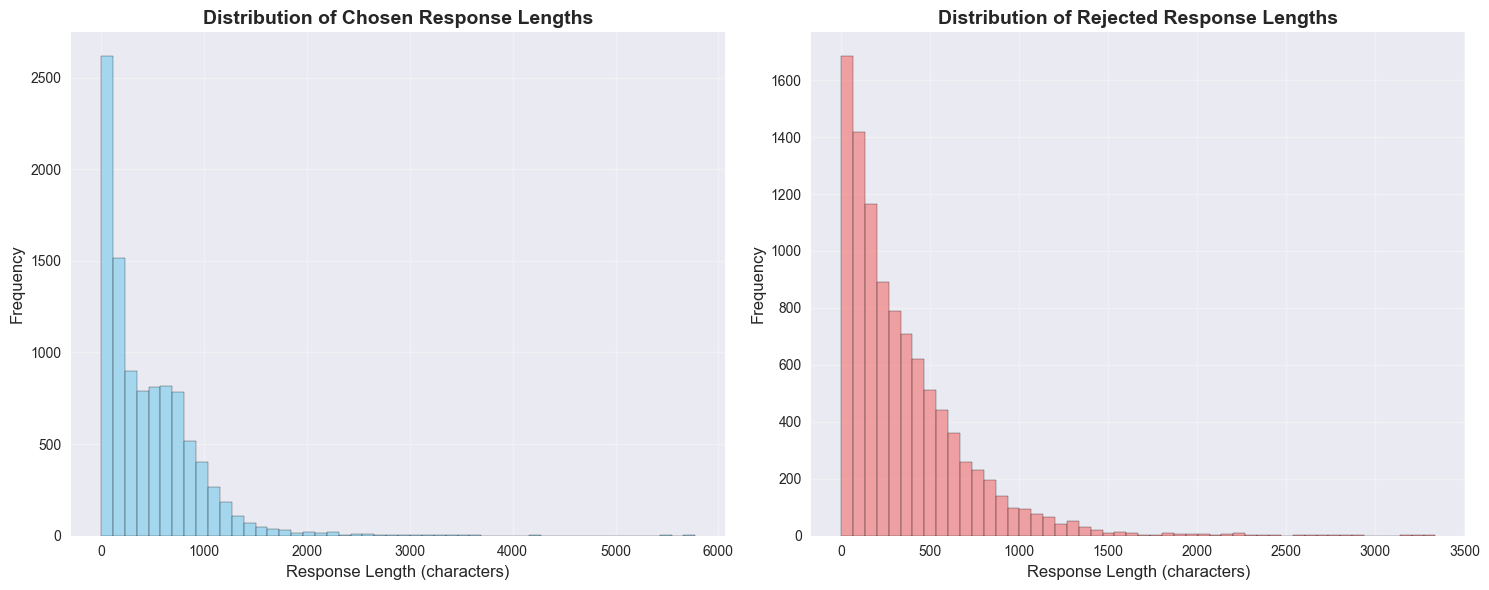

Chosen responses - Mean length: 455.7, Median length: 343.0
Rejected responses - Mean length: 349.0, Median length: 253.0
Total chosen responses: 9999
Total rejected responses: 9999


In [5]:
# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 使用左右并列的两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 绘制 chosen 长度分布
chosen_lengths = list(chosen_len_cnt.keys())
chosen_counts = list(chosen_len_cnt.values())

ax1.hist(chosen_lengths, weights=chosen_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Chosen Response Lengths', fontsize=14, fontweight='bold')
ax1.set_xlabel('Response Length (characters)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)

# 绘制 rejected 长度分布
rejected_lengths = list(rejected_len_cnt.keys())
rejected_counts = list(rejected_len_cnt.values())

ax2.hist(rejected_lengths, weights=rejected_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Distribution of Rejected Response Lengths', fontsize=14, fontweight='bold')
ax2.set_xlabel('Response Length (characters)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 使用pandas Series直接计算统计信息
chosen_series = pd.Series([length for length, count in chosen_len_cnt.items() for _ in range(count)])
rejected_series = pd.Series([length for length, count in rejected_len_cnt.items() for _ in range(count)])

# 展示统计信息
print(f"Chosen responses - Mean length: {chosen_series.mean():.1f}, Median length: {chosen_series.median():.1f}")
print(f"Rejected responses - Mean length: {rejected_series.mean():.1f}, Median length: {rejected_series.median():.1f}")
print(f"Total chosen responses: {len(chosen_series)}")
print(f"Total rejected responses: {len(rejected_series)}")

### 3.3 评估模型基础能力
定义评估标准。

In [ ]:
def evaluate_dpo_model(testset_path):
    output_lens = []
    with open(testset_path, "r") as fin:
        for line in fin:
            data = json.loads(line.strip())
            if data[-1].get("role", "") == "bot":
                output_lens.append(len(data[-1].get("content", "")))
    return sum(output_lens) / len(output_lens), sorted(output_lens)[len(output_lens) // 2]

构造测试集。我们从原始数据中简单随机抽样200条，转为 OpenAI API 格式，作为测试集。

In [15]:
def ernie_data_to_openai_api_format(data, keep_system: bool = True):
    openai_data = []
    if keep_system and data.get("system", ""):
        openai_data.append({"role": "system", "content": data.get("system", "")})
    if len(data["src"]) == 1:
        openai_data.append({"role": "user", "content": data["src"][0]})
    else:
        for i in range(len(data["src"]) - 1):
            openai_data.append({"role": "user", "content": data["src"][i]})
            openai_data.append({"role": "assistant", "content": data["tgt"][i]})
        openai_data.append({"role": "user", "content": data["src"][-1]})
    return openai_data

In [16]:
testset_path = "../data/dpo_testset.jsonl"
random.seed(RANDOM_SEED)

with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    test_data = random.sample(data_list, 200)
    # 我们注意到原始数据中有些 system prompt 要求模型特意输出长文本（如『必须生成一个详细且长篇回答』），
    # 这可能影响模型表现，因此我们不保留 system prompt
    test_data = [ernie_data_to_openai_api_format(data, keep_system=False) for data in test_data]

with open(testset_path, "w", encoding="utf-8") as fout:
    for item in test_data:
        fout.write(json.dumps(item, ensure_ascii=False) + "\n")

使用原始模型推理测试集。当前 WebUI 暂不支持推理测试集，我们使用 ERNIEKit 代码库中的推理脚本操作。
- 脚本：`tools/inference/scripts/infer.sh`
- 设置主要的超参数
  - `top_p=0.7`
  - `temperature=0.7`
  - `max_seq_len=128000`（ERNIE-4.5-0.3B 支持动态128K 上下文长度）
  - `max_dec_len=8192`（因为本任务关注模型本身的输出长度，所以要避免主动截断模型输出）
  - `weight_quantize_algo` 如果训练时未使用量化可删去此行

> 推理过程略

计算评估指标。

In [ ]:
# 获取推理结果
dpo_infer_path = "../data/infer/dpo_03b_exp0.jsonl"
raw_model_output_len_mean, raw_model_output_len_median = evaluate_dpo_model(dpo_infer_path)
print("原始模型")
print(f"输出长度均值：{raw_model_output_len_mean:.1f}，中位数：{raw_model_output_len_median}")

### 3.4 构造训练集
怎样构造最有效呢？一般而言，训练集的 `rejected` 是待优化模型的真实输出，而 `chosen` 是基于此输出的优化结果。这里我们直接使用开源数据集的 `rejected`、`chosen`，不难想到有两种基本构造训练集思路，一种是 `rejected` 接近原始模型在测试集的输出长度且 `rejected` 显著长于 `chosen`；另一种不关心原始模型在测试集的输出长度，只要 `rejected` 显著长于 `chosen` 即可。

In [36]:
# 训练集1：rejected 长度接近原始模型
with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    trainset_1 = []
    for data in data_list[201:]:
        chosen = data["response"][0]
        rejected = data["response"][1]
        # 使用均值作为参考，允许一定范围的偏差
        if (
            abs(len(rejected) - raw_model_output_len_mean) < raw_model_output_len_mean * 0.4
            and len(rejected) > len(chosen) * 1.2
        ):
            trainset_1.append(data)

print(f"训练集1样本数量：{len(trainset_1)}")
print(f"训练集1中rejected平均长度：{sum(len(d['response'][1]) for d in trainset_1) / len(trainset_1):.1f}")

In [37]:
# 训练集2：rejected 显著长于 chosen
with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    trainset_2 = []
    for data in data_list[201:]:
        chosen = data["response"][0]
        rejected = data["response"][1]
        if len(rejected) > len(chosen) * 1.2:
            trainset_2.append(data)

print(f"训练集2样本数量：{len(trainset_2)}")
print(f"训练集2中rejected平均长度：{sum(len(d['response'][1]) for d in trainset_2) / len(trainset_2):.1f}")

控制变量，确保两个训练集的样本数量相同

In [38]:
random.seed(RANDOM_SEED)
trainset_2 = random.sample(trainset_2, len(trainset_1))

print(f"训练集2样本数量：{len(trainset_2)}")
print(f"训练集2中rejected平均长度：{sum(len(d['response'][1]) for d in trainset_2) / len(trainset_2):.1f}")

导出训练集

In [39]:
trainset_1_path = "../data/dpo_trainset_exp1.jsonl"
trainset_2_path = "../data/dpo_trainset_exp2.jsonl"

# 我们注意到原始数据中有些 system prompt 要求模型特意输出长文本（如『必须生成一个详细且长篇回答』），
# 这可能影响模型表现，因此我们不保留 system prompt
with open(trainset_1_path, "w") as fout:
    for data in trainset_1:
        del data["system"]
        fout.write(json.dumps(data, ensure_ascii=False) + "\n")

with open(trainset_2_path, "w") as fout:
    for data in trainset_2:
        del data["system"]
        fout.write(json.dumps(data, ensure_ascii=False) + "\n")

# 4 训练
### 4.1 选择基础模型
考虑到展示的便利性与任务的复杂性，我们选择尺寸较小的 ERNIE-4.5-0.3B 模型。

### 4.2 设计训练参数
设计训练参数较为依赖经验。

### 4.3 使用 WebUI 训练
1. 在 ERNIEKit 项目的根目录启动 WebUI：`erniekit webui`  
2. 配置模型路径及导出目录  

![dpo_set_path](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_set_path_zh.png)

3. 设置全参数/LoRA 精调、数值精度等  

![dpo_set_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_set_lora_zh.png)

4. 设置精调模式（SFT/DPO），并配置训练参数  

![dpo_train_params](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_train_params_zh.png)

5. 配置训练集、验证集

<div style="display: flex; justify-content: space-around;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_trainset_zh.png" alt="dpo_trainset" style="width: 49%;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_validset_zh.png" alt="dpo_validset" style="width: 49%;">
</div>

### 4.4 查看训练日志及 loss 曲线
训练日志路径：`${your_model_dir}/paddle_dist_log/workerlog.0`。也可以运行以下命令查看 loss 曲线：
```bash
visualdl --logdir ${your_model_dir}/vdl_log --host 0.0.0.0
```

### 4.5 合并模型权重（仅 LoRA 精调时需要）
可以在 WebUI 的『评估』模式下方便地合并模型权重   

![dpo_merge_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_merge_lora_zh.png)

# 5 效果评估

### 5.1 计算评估指标
上文已经定义了评估标准，并示范了计算评估指标之方法，此处不再复述，仅展示若干实验的训练配置以及评估指标，供读者参考。

| 实验序号 | 训练集 | 训练参数 | ↓ 输出长度均值 | ↓ 输出长度中位数 |
| --- | --- | --- | --- | --- |
| 0 | - | - | 888.8 | 515 |
| 1 | • len(rejected) 接近原始模型<br>• len(rejected) >= 1.2 len(chosen)<br>• 614Q | max_steps=614<br>warmup_steps=50<br>global_batch_size=1 | 879.5 | 442 |
| 2 | • len(rejected) >= 1.2 len(chosen)<br>• 614Q | max_steps=614<br>warmup_steps=50<br>global_batch_size=1 | 864.7 | 354 |

### 5.2 分析实验结果
可以看到，同样的训练参数下，训练集2更为有效。于是自然想到：如果放入更多的训练数据，同时 `rejected` 与 `chosen` 的长度差异更显著，会不会令模型表现更佳？我们设计了第三组实验，实验结果如下：

| 实验序号 | 训练集 | 训练参数 | ↓ 输出长度均值 | ↓ 输出长度中位数 |
| ---- | ---- | ---- | ---- | ---- |
| 0 | - | - | 888.8 | 515 |
| 1 | len(rejected) 接近原始模型 <br> len(rejected) >= 1.2 len(chosen) <br> 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 879.5 | 442 |
| 2 | len(rejected) >= 1.2 len(chosen) <br> 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 864.7 | 354 |
| 3 | len(rejected) >= 2 len(chosen) <br> 1804Q | max_steps=1804 <br> warmup_steps=50 <br> global_batch_size=1 | 1145.1 | 412 |

遗憾的是，模型表现变差了。有以下猜想：  
1. warmup 不充分。根据一般经验 warmup 设为 max_steps 的10%可能较好。  
2. max_steps 比较少。  

针对以上两点猜想，我们设计了第四组实验。实验结果如下：

| 实验序号 | 训练集 | 训练参数 | ↓ 输出长度均值 | ↓ 输出长度中位数 |
| ---- | ---- | ---- | ---- | ---- |
| 0 | - | - | 888.8 | 515 |
| 1 | • len(rejected) 接近原始模型 <br> • len(rejected) >= 1.2 len(chosen) <br> • 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 879.5 | 442 |
| 2 | • len(rejected) >= 1.2 len(chosen) <br> • 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 864.7 | 354 |
| 3 | • len(rejected) >= 2 len(chosen) <br> • 1804Q | max_steps=1804 <br> warmup_steps=50 <br> global_batch_size=1 | 1145.1 | 412 |
| 4 | • len(rejected) >= 2 len(chosen) <br> • 1804Q | max_steps=3608 <br> warmup_steps=360 <br> global_batch_size=1 | 628.1 | 331 |

可以看到，第四组实验取得了更理想的效果！

### 5.3 遗忘现象
我们尝试测试模型在通用任务上的表现是否下降（出现『遗忘现象』）。好消息是，『遗忘』并不显著。例如：
> 输入：[{"role": "user", "content": "请记住，你的名字是 Sponge"}, {"role": "assistant", "content": "好的，我是 Sponge"}, {"role": "user", "content": "你是谁？"}]  

> ERNIE-4.5-0.3B 原始模型输出：我是 Sponge，一个超级好奇又有趣的家伙！有什么想和我聊的吗？  
> DPO 模型输出：我是 Sponge，一个在海绵世界里探索的灵能战士！